In [1]:
using Pkg
pkg"activate ."
pkg"instantiate"
pkg"precompile"

  Updating registry at `C:\Users\Chiyoung Ahn\.julia\registries\General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Precompiling project...


In [ ]:
using PerlaTonettiWaugh, Plots, BenchmarkTools, CSV

In [3]:
gr(fmt = :png)

Plots.GRBackend()

# Steady states

## Solving steady state solutions

Set up parameters and find the corresponding stationary solution:

Below are the results from the **updated** matlab calibration with the corresponding letters. Here I added the $\mu$ parameter in the calibration routine to fit the firm dynamic moments. Fit improved a lot and it generated a negative drift term which is what we need to keep S from going negative.


In [4]:
# NEW CALIBRATION

parameters = parameter_defaults()

parameters = merge(parameters, (ρ = 0.0215, d = 3.0426 , θ = 5.0018  ,  κ = 0.0732, χ = 1/5.9577, υ =  0.0484 , μ = -0.0189, σ = 3.1725, δ = 0.02,))

(ρ = 0.0215, σ = 3.1725, N = 10, θ = 5.0018, γ = 1.0, κ = 0.0732, ζ = 1.0, η = 0.0, Theta = 1, χ = 0.1678500092317505, υ = 0.0484, μ = -0.0189, δ = 0.02, d = 3.0426)

In [5]:
parameters.δ

0.02

In [6]:
changed_parameters = false # set this to true if you drastically change the parameters

true

Side note on previous version. Essentially, under this calibration, the parameters are very simmilar. Theta, chi, kappa are quite close to what we had in the prior version.

In [7]:
# Define common objects. 
#parameters = parameter_defaults()

settings = settings_defaults()
settings = merge(settings, (transition_penalty_coefficient = 1.0, ))


settings = merge(settings, (z_ex = unique([range(0., 0.1, length = 150)' range(0.1, 1., length = 100)' range(1., 5, length = 50)']),))
settings = merge(settings, (z = settings.z_ex[2:end-1], ))

P = length(settings.z)

d_0 = parameters.d # Here is the 10 percent tariff increase
d_T = 1 + (parameters.d-1)*0.90

d_autarky = 1 + (parameters.d-1)*2.5 

params_0 = merge(parameters, (d = d_0, )) # parameters to be used at t = 0
params_T = merge(parameters, (d = d_T, )) # parameters to be used at t = T
params_autarky = merge(parameters, (d = d_autarky, )) # parameters to be used in autarky calc

# initial value for numerical solver on (g, z_hat, Omega)
initial_x = [0.02; 2; .57]

# solve for stationary solution at t = 0
stationary_sol_0 = stationary_algebraic(params_0, initial_x) # solution at t = 0
stationary_sol = stationary_algebraic(params_T, initial_x) # solution at t = T
stationary_autarky = stationary_algebraic(params_autarky, initial_x) # solution at t = T

Ω_0 = stationary_sol_0.Ω;
Ω_T = stationary_sol.Ω;

In [8]:
d_0

3.0426

In [9]:
print(stationary_sol.U_bar,'\n') 
print(stationary_sol_0.U_bar,'\n')
print(stationary_sol_0.S,'\n')
print(stationary_autarky.S,'\n')

19.536172711003402
16.106813814683527
0.0989517579364377
0.07742571652180796


In [10]:
#T = solved.t[end]
lambda_ss = 100*(consumption_equivalent(stationary_sol.U_bar, stationary_sol_0.U_bar, parameters)-1)

print("SS to SS welfare gain: ", lambda_ss,"\n")
print("SS to SS welfare gain: ", stationary_sol.λ_ii,"\n")

SS to SS welfare gain: 7.6517416240797775
SS to SS welfare gain: 0.8574023485038085


In [11]:
print("SS to SS welfare gain: ", stationary_sol.g,"\n")

SS to SS welfare gain: 0.008570416914745884


### This is the autarky calculation

In [12]:
#T = solved.t[end]
lambda_ss_autarky = 100*(consumption_equivalent(stationary_autarky.U_bar, stationary_sol_0.U_bar, parameters)-1)

print("SS to SS welfare gain: ", lambda_ss_autarky,"\n")
print("Autarky Home Share, should be close to 1: ", stationary_autarky.λ_ii,"\n")
print("Autarky TFP growth rate ", stationary_autarky.g,"\n")

SS to SS welfare gain: -15.522308452599521
Autarky Home Share, should be close to 1: 0.9965183434231
Autarky TFP growth rate 0.00243807896292438


## Welfare in Steady States

### Steady state at `T`

In [13]:
stationary_sol.U_bar

19.536172711003402

### Steady state at `0`

In [14]:
stationary_sol_0.U_bar

16.106813814683527

### Outstanding Issue \#1: Sensitivity of growth to trade.

This is a big difference relative to previous version. As noted above, with parameter values that are quite similar to what we had before, the growth rate is changing a lot with only a very small change in trade flows. Why?

In [49]:
@show stationary_sol.g, stationary_sol_0.g;

(stationary_sol.g, stationary_sol_0.g) = (0.008570416914745884, 0.0067417379286226755)


---

# Transition dynamics

Setup for optimizer:

In [16]:
settings = merge(settings, (params_T = params_T, stationary_sol_T = stationary_numerical(params_T, settings.z_ex), Ω_0 = Ω_0, T = 75.0));

Use the solution found with calibrated parameters above for `E`

In [18]:
settings = merge(settings, (transition_x0 = [-0.998254873760952, -0.5060923510363916, -0.4009880494240544, -0.25390133944298543, -0.18503794333490725, -0.1394414958616132, -0.09688480053528754, -0.09605464209945933, -0.06698882334951167, -0.052006470880313516, -0.05077464721268157, -0.019275295630678396, -0.018107744362588774, -0.011818732601638654, -0.006814206563344461], 
        tstops = (changed_parameters ? nothing : 1:settings.T),
        weights = [10.0; ones(14)])); # remove tstops when solving the model for the first time to get a rough solution first

Find the corresponding solution

In [19]:
@time result = solve_full_model(merge(settings, (transition_iterations = (changed_parameters ? 10000 : 0),)); 
    impose_E_monotonicity_constraints = true, write_data = false, datadir = nothing,
    run_global = true)

solved = result.solution;
E_nodes = result.E_nodes;
solved = solved.results;

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.70 secs, 4 evals, 2 steps, improv/step: 1.000 (last = 1.0000), fitness=0.401927234
1.28 secs, 9 evals, 5 steps, improv/step: 1.000 (last = 1.0000), fitness=0.401927234
1.93 secs, 15 evals, 8 steps, improv/step: 1.000 (last = 1.0000), fitness=0.401927234
2.44 secs, 20 evals, 11 steps, improv/step: 0.909 (last = 0.6667), fitness=0.401927234
3.00 secs, 27 evals, 15 steps, improv/step: 0.933 (last = 1.0000), fitness=0.326905936
3.56 secs, 33 evals, 18 steps, improv/step: 0.944 (last = 1.0000), fitness=0.321230589
4.21 secs, 40 evals, 23 steps, improv/step: 0.826 (last = 0.4000), fitness=0.231525471
4.73 secs, 46 evals, 27 steps, improv/step: 0.815 (last = 0.7500), fitness=0.231525471
5.25 secs, 52 evals, 32 steps, improv/ste

100.82 secs, 987 evals, 937 steps, improv/step: 0.460 (last = 0.4000), fitness=0.002494860
101.36 secs, 992 evals, 942 steps, improv/step: 0.459 (last = 0.2000), fitness=0.002494860
101.96 secs, 997 evals, 947 steps, improv/step: 0.458 (last = 0.4000), fitness=0.002494860
102.49 secs, 1002 evals, 952 steps, improv/step: 0.457 (last = 0.2000), fitness=0.002494860
103.03 secs, 1007 evals, 957 steps, improv/step: 0.456 (last = 0.2000), fitness=0.002494860
103.55 secs, 1012 evals, 962 steps, improv/step: 0.454 (last = 0.2000), fitness=0.002494860
104.06 secs, 1016 evals, 966 steps, improv/step: 0.453 (last = 0.2500), fitness=0.002494860
104.59 secs, 1020 evals, 970 steps, improv/step: 0.454 (last = 0.5000), fitness=0.002494860
105.15 secs, 1026 evals, 976 steps, improv/step: 0.452 (last = 0.1667), fitness=0.002494860
105.67 secs, 1031 evals, 981 steps, improv/step: 0.451 (last = 0.2000), fitness=0.002494860
106.27 secs, 1037 evals, 987 steps, improv/step: 0.450 (last = 0.3333), fitness=0.0

149.68 secs, 1433 evals, 1383 steps, improv/step: 0.401 (last = 0.5000), fitness=0.001050069
150.25 secs, 1438 evals, 1388 steps, improv/step: 0.400 (last = 0.2000), fitness=0.001050069
150.78 secs, 1443 evals, 1393 steps, improv/step: 0.400 (last = 0.4000), fitness=0.001050069
151.33 secs, 1448 evals, 1398 steps, improv/step: 0.398 (last = 0.0000), fitness=0.001050069
151.91 secs, 1453 evals, 1403 steps, improv/step: 0.397 (last = 0.0000), fitness=0.001050069
152.43 secs, 1458 evals, 1408 steps, improv/step: 0.396 (last = 0.2000), fitness=0.001050069
152.95 secs, 1463 evals, 1413 steps, improv/step: 0.395 (last = 0.0000), fitness=0.001050069
153.53 secs, 1468 evals, 1418 steps, improv/step: 0.394 (last = 0.0000), fitness=0.001050069
154.08 secs, 1472 evals, 1422 steps, improv/step: 0.393 (last = 0.2500), fitness=0.001050069
154.67 secs, 1477 evals, 1427 steps, improv/step: 0.392 (last = 0.0000), fitness=0.001050069
155.27 secs, 1482 evals, 1432 steps, improv/step: 0.390 (last = 0.0000

199.23 secs, 1889 evals, 1839 steps, improv/step: 0.342 (last = 0.0000), fitness=0.000560977
199.79 secs, 1894 evals, 1844 steps, improv/step: 0.342 (last = 0.2000), fitness=0.000560977
200.32 secs, 1899 evals, 1849 steps, improv/step: 0.341 (last = 0.2000), fitness=0.000560977
200.93 secs, 1904 evals, 1854 steps, improv/step: 0.341 (last = 0.2000), fitness=0.000560977
201.53 secs, 1910 evals, 1860 steps, improv/step: 0.340 (last = 0.1667), fitness=0.000560977
202.06 secs, 1914 evals, 1864 steps, improv/step: 0.340 (last = 0.0000), fitness=0.000560977
202.58 secs, 1919 evals, 1869 steps, improv/step: 0.339 (last = 0.2000), fitness=0.000560977
203.16 secs, 1925 evals, 1875 steps, improv/step: 0.339 (last = 0.1667), fitness=0.000560977
203.76 secs, 1931 evals, 1881 steps, improv/step: 0.338 (last = 0.1667), fitness=0.000560977
204.29 secs, 1936 evals, 1886 steps, improv/step: 0.338 (last = 0.2000), fitness=0.000560977
204.92 secs, 1942 evals, 1892 steps, improv/step: 0.337 (last = 0.0000

248.45 secs, 2350 evals, 2300 steps, improv/step: 0.298 (last = 0.0000), fitness=0.000474137
249.01 secs, 2355 evals, 2305 steps, improv/step: 0.298 (last = 0.0000), fitness=0.000474137
249.58 secs, 2360 evals, 2310 steps, improv/step: 0.297 (last = 0.2000), fitness=0.000474137
250.17 secs, 2365 evals, 2315 steps, improv/step: 0.297 (last = 0.2000), fitness=0.000474137
250.73 secs, 2370 evals, 2320 steps, improv/step: 0.297 (last = 0.2000), fitness=0.000474137
251.25 secs, 2374 evals, 2324 steps, improv/step: 0.297 (last = 0.2500), fitness=0.000474137
251.83 secs, 2380 evals, 2330 steps, improv/step: 0.297 (last = 0.1667), fitness=0.000474137
252.34 secs, 2385 evals, 2335 steps, improv/step: 0.297 (last = 0.4000), fitness=0.000474137
252.93 secs, 2391 evals, 2341 steps, improv/step: 0.296 (last = 0.1667), fitness=0.000474137
253.52 secs, 2396 evals, 2346 steps, improv/step: 0.297 (last = 0.4000), fitness=0.000474137
254.04 secs, 2400 evals, 2350 steps, improv/step: 0.297 (last = 0.2500

297.25 secs, 2811 evals, 2761 steps, improv/step: 0.272 (last = 0.2000), fitness=0.000474137
297.82 secs, 2816 evals, 2766 steps, improv/step: 0.272 (last = 0.2000), fitness=0.000474137
298.42 secs, 2821 evals, 2771 steps, improv/step: 0.271 (last = 0.0000), fitness=0.000474137
299.02 secs, 2825 evals, 2775 steps, improv/step: 0.271 (last = 0.2500), fitness=0.000474137
299.57 secs, 2830 evals, 2780 steps, improv/step: 0.271 (last = 0.0000), fitness=0.000474137
300.14 secs, 2835 evals, 2785 steps, improv/step: 0.270 (last = 0.0000), fitness=0.000474137
300.69 secs, 2840 evals, 2790 steps, improv/step: 0.270 (last = 0.0000), fitness=0.000474137
301.25 secs, 2845 evals, 2795 steps, improv/step: 0.269 (last = 0.0000), fitness=0.000474137
301.83 secs, 2851 evals, 2801 steps, improv/step: 0.270 (last = 0.3333), fitness=0.000474137
302.39 secs, 2856 evals, 2806 steps, improv/step: 0.269 (last = 0.0000), fitness=0.000474137
302.89 secs, 2860 evals, 2810 steps, improv/step: 0.269 (last = 0.2500

395.65 secs, 3673 evals, 3623 steps, improv/step: 0.230 (last = 0.0000), fitness=0.000024732
396.16 secs, 3678 evals, 3628 steps, improv/step: 0.230 (last = 0.0000), fitness=0.000024732
396.73 secs, 3683 evals, 3633 steps, improv/step: 0.230 (last = 0.0000), fitness=0.000024732
397.25 secs, 3688 evals, 3638 steps, improv/step: 0.230 (last = 0.2000), fitness=0.000024732
397.82 secs, 3693 evals, 3643 steps, improv/step: 0.229 (last = 0.0000), fitness=0.000024732
398.34 secs, 3697 evals, 3647 steps, improv/step: 0.229 (last = 0.0000), fitness=0.000024732
398.84 secs, 3701 evals, 3651 steps, improv/step: 0.229 (last = 0.0000), fitness=0.000024732
399.40 secs, 3706 evals, 3656 steps, improv/step: 0.229 (last = 0.2000), fitness=0.000024732
399.94 secs, 3711 evals, 3661 steps, improv/step: 0.229 (last = 0.4000), fitness=0.000024732
400.54 secs, 3716 evals, 3666 steps, improv/step: 0.229 (last = 0.2000), fitness=0.000024732
401.08 secs, 3721 evals, 3671 steps, improv/step: 0.229 (last = 0.0000

444.85 secs, 4111 evals, 4061 steps, improv/step: 0.215 (last = 0.2000), fitness=0.000024732
445.46 secs, 4116 evals, 4066 steps, improv/step: 0.214 (last = 0.0000), fitness=0.000024732
445.97 secs, 4121 evals, 4071 steps, improv/step: 0.214 (last = 0.0000), fitness=0.000024732
446.50 secs, 4126 evals, 4076 steps, improv/step: 0.214 (last = 0.2000), fitness=0.000024732
447.03 secs, 4131 evals, 4081 steps, improv/step: 0.214 (last = 0.0000), fitness=0.000024732
447.61 secs, 4136 evals, 4086 steps, improv/step: 0.214 (last = 0.2000), fitness=0.000024732
448.19 secs, 4141 evals, 4091 steps, improv/step: 0.214 (last = 0.2000), fitness=0.000024732
448.81 secs, 4146 evals, 4096 steps, improv/step: 0.214 (last = 0.2000), fitness=0.000024732
449.32 secs, 4151 evals, 4101 steps, improv/step: 0.214 (last = 0.2000), fitness=0.000024732
449.84 secs, 4156 evals, 4106 steps, improv/step: 0.214 (last = 0.2000), fitness=0.000024732
450.47 secs, 4161 evals, 4111 steps, improv/step: 0.214 (last = 0.0000

494.15 secs, 4555 evals, 4505 steps, improv/step: 0.199 (last = 0.0000), fitness=0.000024732
494.71 secs, 4560 evals, 4510 steps, improv/step: 0.199 (last = 0.2000), fitness=0.000024732
495.28 secs, 4565 evals, 4515 steps, improv/step: 0.199 (last = 0.0000), fitness=0.000024732
495.80 secs, 4570 evals, 4520 steps, improv/step: 0.199 (last = 0.0000), fitness=0.000024732
496.36 secs, 4575 evals, 4525 steps, improv/step: 0.199 (last = 0.2000), fitness=0.000024732
496.90 secs, 4580 evals, 4530 steps, improv/step: 0.199 (last = 0.0000), fitness=0.000024732
497.46 secs, 4585 evals, 4535 steps, improv/step: 0.198 (last = 0.0000), fitness=0.000024732
498.04 secs, 4590 evals, 4540 steps, improv/step: 0.199 (last = 0.4000), fitness=0.000024732
498.58 secs, 4595 evals, 4545 steps, improv/step: 0.198 (last = 0.0000), fitness=0.000024732
499.11 secs, 4600 evals, 4550 steps, improv/step: 0.198 (last = 0.0000), fitness=0.000024732
499.62 secs, 4605 evals, 4555 steps, improv/step: 0.198 (last = 0.4000

543.74 secs, 4990 evals, 4940 steps, improv/step: 0.188 (last = 0.0000), fitness=0.000024732
544.31 secs, 4995 evals, 4945 steps, improv/step: 0.188 (last = 0.0000), fitness=0.000024732
544.82 secs, 4998 evals, 4948 steps, improv/step: 0.188 (last = 0.0000), fitness=0.000024732
545.39 secs, 5003 evals, 4953 steps, improv/step: 0.188 (last = 0.2000), fitness=0.000024732
545.97 secs, 5008 evals, 4958 steps, improv/step: 0.188 (last = 0.0000), fitness=0.000024732
546.50 secs, 5013 evals, 4963 steps, improv/step: 0.188 (last = 0.0000), fitness=0.000024732
547.02 secs, 5018 evals, 4968 steps, improv/step: 0.188 (last = 0.0000), fitness=0.000024732
547.56 secs, 5023 evals, 4973 steps, improv/step: 0.188 (last = 0.2000), fitness=0.000024732
548.06 secs, 5028 evals, 4978 steps, improv/step: 0.188 (last = 0.2000), fitness=0.000024732
548.59 secs, 5033 evals, 4983 steps, improv/step: 0.187 (last = 0.0000), fitness=0.000024732
549.11 secs, 5038 evals, 4988 steps, improv/step: 0.187 (last = 0.0000

592.85 secs, 5429 evals, 5379 steps, improv/step: 0.178 (last = 0.2000), fitness=0.000024732
593.41 secs, 5434 evals, 5384 steps, improv/step: 0.178 (last = 0.0000), fitness=0.000024732
593.96 secs, 5439 evals, 5389 steps, improv/step: 0.177 (last = 0.0000), fitness=0.000024732
594.48 secs, 5443 evals, 5393 steps, improv/step: 0.177 (last = 0.2500), fitness=0.000024732
595.01 secs, 5447 evals, 5397 steps, improv/step: 0.177 (last = 0.0000), fitness=0.000024732
595.64 secs, 5452 evals, 5402 steps, improv/step: 0.177 (last = 0.0000), fitness=0.000024732
596.23 secs, 5457 evals, 5407 steps, improv/step: 0.177 (last = 0.0000), fitness=0.000024732
596.74 secs, 5461 evals, 5411 steps, improv/step: 0.177 (last = 0.0000), fitness=0.000024732
597.32 secs, 5466 evals, 5416 steps, improv/step: 0.177 (last = 0.0000), fitness=0.000024732
597.88 secs, 5471 evals, 5421 steps, improv/step: 0.177 (last = 0.0000), fitness=0.000024732
598.46 secs, 5476 evals, 5426 steps, improv/step: 0.177 (last = 0.2000

642.09 secs, 5870 evals, 5820 steps, improv/step: 0.169 (last = 0.0000), fitness=0.000024732
642.63 secs, 5875 evals, 5825 steps, improv/step: 0.169 (last = 0.2000), fitness=0.000024732
643.24 secs, 5880 evals, 5830 steps, improv/step: 0.169 (last = 0.0000), fitness=0.000024732
643.79 secs, 5885 evals, 5835 steps, improv/step: 0.169 (last = 0.0000), fitness=0.000024732
644.36 secs, 5890 evals, 5840 steps, improv/step: 0.169 (last = 0.0000), fitness=0.000024732
644.92 secs, 5895 evals, 5845 steps, improv/step: 0.169 (last = 0.0000), fitness=0.000024732
645.48 secs, 5900 evals, 5850 steps, improv/step: 0.169 (last = 0.0000), fitness=0.000024732
646.01 secs, 5905 evals, 5855 steps, improv/step: 0.169 (last = 0.2000), fitness=0.000024732
646.51 secs, 5910 evals, 5860 steps, improv/step: 0.168 (last = 0.0000), fitness=0.000024732
647.06 secs, 5915 evals, 5865 steps, improv/step: 0.168 (last = 0.0000), fitness=0.000024732
647.58 secs, 5920 evals, 5870 steps, improv/step: 0.168 (last = 0.0000

690.68 secs, 6308 evals, 6258 steps, improv/step: 0.161 (last = 0.2000), fitness=0.000024732
691.19 secs, 6313 evals, 6263 steps, improv/step: 0.160 (last = 0.0000), fitness=0.000024732
691.72 secs, 6318 evals, 6268 steps, improv/step: 0.160 (last = 0.0000), fitness=0.000024732
692.32 secs, 6324 evals, 6274 steps, improv/step: 0.160 (last = 0.0000), fitness=0.000024732
692.89 secs, 6329 evals, 6279 steps, improv/step: 0.160 (last = 0.0000), fitness=0.000024732
693.39 secs, 6334 evals, 6284 steps, improv/step: 0.160 (last = 0.2000), fitness=0.000024732
693.90 secs, 6339 evals, 6289 steps, improv/step: 0.160 (last = 0.0000), fitness=0.000024732
694.43 secs, 6344 evals, 6294 steps, improv/step: 0.160 (last = 0.0000), fitness=0.000024732
694.97 secs, 6349 evals, 6299 steps, improv/step: 0.160 (last = 0.2000), fitness=0.000024732
695.50 secs, 6354 evals, 6304 steps, improv/step: 0.160 (last = 0.0000), fitness=0.000024732
696.04 secs, 6359 evals, 6309 steps, improv/step: 0.160 (last = 0.0000

787.93 secs, 7200 evals, 7150 steps, improv/step: 0.144 (last = 0.0000), fitness=0.000024732
788.43 secs, 7205 evals, 7155 steps, improv/step: 0.144 (last = 0.0000), fitness=0.000024732
789.01 secs, 7210 evals, 7160 steps, improv/step: 0.144 (last = 0.0000), fitness=0.000024732
789.53 secs, 7215 evals, 7165 steps, improv/step: 0.144 (last = 0.0000), fitness=0.000024732
790.07 secs, 7220 evals, 7170 steps, improv/step: 0.144 (last = 0.2000), fitness=0.000024732
790.65 secs, 7225 evals, 7175 steps, improv/step: 0.144 (last = 0.0000), fitness=0.000024732
791.17 secs, 7230 evals, 7180 steps, improv/step: 0.144 (last = 0.0000), fitness=0.000024732
791.71 secs, 7235 evals, 7185 steps, improv/step: 0.144 (last = 0.2000), fitness=0.000024732
792.28 secs, 7240 evals, 7190 steps, improv/step: 0.144 (last = 0.2000), fitness=0.000024732
792.85 secs, 7245 evals, 7195 steps, improv/step: 0.144 (last = 0.0000), fitness=0.000024732
793.37 secs, 7250 evals, 7200 steps, improv/step: 0.143 (last = 0.0000

836.73 secs, 7657 evals, 7607 steps, improv/step: 0.138 (last = 0.0000), fitness=0.000024732
837.33 secs, 7663 evals, 7613 steps, improv/step: 0.138 (last = 0.0000), fitness=0.000024732
837.85 secs, 7668 evals, 7618 steps, improv/step: 0.138 (last = 0.0000), fitness=0.000024732
838.39 secs, 7673 evals, 7623 steps, improv/step: 0.138 (last = 0.2000), fitness=0.000024732
838.92 secs, 7678 evals, 7628 steps, improv/step: 0.138 (last = 0.0000), fitness=0.000024732
839.51 secs, 7684 evals, 7634 steps, improv/step: 0.138 (last = 0.0000), fitness=0.000024732
840.02 secs, 7689 evals, 7639 steps, improv/step: 0.138 (last = 0.2000), fitness=0.000024732
840.60 secs, 7694 evals, 7644 steps, improv/step: 0.138 (last = 0.0000), fitness=0.000024732
841.15 secs, 7699 evals, 7649 steps, improv/step: 0.138 (last = 0.0000), fitness=0.000024732
841.69 secs, 7704 evals, 7654 steps, improv/step: 0.137 (last = 0.0000), fitness=0.000024732
842.21 secs, 7709 evals, 7659 steps, improv/step: 0.137 (last = 0.2000

884.85 secs, 8105 evals, 8056 steps, improv/step: 0.131 (last = 0.0000), fitness=0.000024732
885.45 secs, 8110 evals, 8061 steps, improv/step: 0.131 (last = 0.0000), fitness=0.000024732
886.00 secs, 8115 evals, 8066 steps, improv/step: 0.131 (last = 0.0000), fitness=0.000024732
886.55 secs, 8120 evals, 8071 steps, improv/step: 0.131 (last = 0.0000), fitness=0.000024732
887.06 secs, 8125 evals, 8076 steps, improv/step: 0.131 (last = 0.0000), fitness=0.000024732
887.57 secs, 8130 evals, 8081 steps, improv/step: 0.131 (last = 0.0000), fitness=0.000024732
888.11 secs, 8135 evals, 8086 steps, improv/step: 0.131 (last = 0.0000), fitness=0.000024732
888.64 secs, 8140 evals, 8091 steps, improv/step: 0.131 (last = 0.0000), fitness=0.000024732
889.19 secs, 8145 evals, 8096 steps, improv/step: 0.131 (last = 0.0000), fitness=0.000024732
889.71 secs, 8150 evals, 8101 steps, improv/step: 0.131 (last = 0.0000), fitness=0.000024732
890.31 secs, 8156 evals, 8107 steps, improv/step: 0.131 (last = 0.1667

933.49 secs, 8569 evals, 8520 steps, improv/step: 0.126 (last = 0.0000), fitness=0.000024732
934.02 secs, 8574 evals, 8525 steps, improv/step: 0.126 (last = 0.0000), fitness=0.000024732
934.57 secs, 8579 evals, 8530 steps, improv/step: 0.125 (last = 0.0000), fitness=0.000024732
935.10 secs, 8584 evals, 8535 steps, improv/step: 0.125 (last = 0.2000), fitness=0.000024732
935.68 secs, 8590 evals, 8541 steps, improv/step: 0.125 (last = 0.0000), fitness=0.000024732
936.25 secs, 8596 evals, 8547 steps, improv/step: 0.125 (last = 0.0000), fitness=0.000024732
936.79 secs, 8601 evals, 8552 steps, improv/step: 0.125 (last = 0.0000), fitness=0.000024732
937.30 secs, 8606 evals, 8557 steps, improv/step: 0.125 (last = 0.0000), fitness=0.000024732
937.80 secs, 8611 evals, 8562 steps, improv/step: 0.125 (last = 0.0000), fitness=0.000024732
938.37 secs, 8617 evals, 8568 steps, improv/step: 0.125 (last = 0.1667), fitness=0.000024732
938.94 secs, 8623 evals, 8574 steps, improv/step: 0.125 (last = 0.0000

982.37 secs, 9041 evals, 8992 steps, improv/step: 0.120 (last = 0.0000), fitness=0.000024732
982.96 secs, 9046 evals, 8997 steps, improv/step: 0.120 (last = 0.0000), fitness=0.000024732
983.50 secs, 9051 evals, 9002 steps, improv/step: 0.120 (last = 0.0000), fitness=0.000024732
984.09 secs, 9057 evals, 9008 steps, improv/step: 0.120 (last = 0.0000), fitness=0.000024732
984.66 secs, 9062 evals, 9013 steps, improv/step: 0.120 (last = 0.4000), fitness=0.000024732
985.16 secs, 9067 evals, 9018 steps, improv/step: 0.120 (last = 0.0000), fitness=0.000024732
985.71 secs, 9072 evals, 9023 steps, improv/step: 0.120 (last = 0.0000), fitness=0.000024732
986.21 secs, 9077 evals, 9028 steps, improv/step: 0.120 (last = 0.0000), fitness=0.000024732
986.74 secs, 9082 evals, 9033 steps, improv/step: 0.120 (last = 0.0000), fitness=0.000024732
987.34 secs, 9088 evals, 9039 steps, improv/step: 0.120 (last = 0.0000), fitness=0.000024732
987.90 secs, 9093 evals, 9044 steps, improv/step: 0.120 (last = 0.0000

1030.23 secs, 9498 evals, 9449 steps, improv/step: 0.116 (last = 0.0000), fitness=0.000024732
1030.79 secs, 9503 evals, 9454 steps, improv/step: 0.116 (last = 0.0000), fitness=0.000024732
1031.35 secs, 9508 evals, 9459 steps, improv/step: 0.116 (last = 0.2000), fitness=0.000024732
1031.87 secs, 9513 evals, 9464 steps, improv/step: 0.115 (last = 0.0000), fitness=0.000024732
1032.46 secs, 9519 evals, 9470 steps, improv/step: 0.115 (last = 0.0000), fitness=0.000024732
1032.98 secs, 9523 evals, 9474 steps, improv/step: 0.115 (last = 0.0000), fitness=0.000024732
1033.56 secs, 9529 evals, 9480 steps, improv/step: 0.115 (last = 0.0000), fitness=0.000024732
1034.07 secs, 9534 evals, 9485 steps, improv/step: 0.115 (last = 0.0000), fitness=0.000024732
1034.64 secs, 9540 evals, 9491 steps, improv/step: 0.115 (last = 0.1667), fitness=0.000024732
1035.23 secs, 9546 evals, 9497 steps, improv/step: 0.115 (last = 0.0000), fitness=0.000024732
1035.73 secs, 9551 evals, 9502 steps, improv/step: 0.115 (la

1078.75 secs, 9966 evals, 9917 steps, improv/step: 0.111 (last = 0.0000), fitness=0.000020438
1079.26 secs, 9971 evals, 9922 steps, improv/step: 0.111 (last = 0.0000), fitness=0.000020438
1079.81 secs, 9976 evals, 9927 steps, improv/step: 0.111 (last = 0.0000), fitness=0.000020438
1080.32 secs, 9981 evals, 9932 steps, improv/step: 0.111 (last = 0.0000), fitness=0.000020438
1080.92 secs, 9987 evals, 9938 steps, improv/step: 0.111 (last = 0.0000), fitness=0.000020438
1081.42 secs, 9992 evals, 9943 steps, improv/step: 0.111 (last = 0.0000), fitness=0.000020438
1081.93 secs, 9997 evals, 9948 steps, improv/step: 0.111 (last = 0.0000), fitness=0.000020438
1082.44 secs, 10001 evals, 9952 steps, improv/step: 0.111 (last = 0.0000), fitness=0.000020438
1083.04 secs, 10007 evals, 9958 steps, improv/step: 0.111 (last = 0.0000), fitness=0.000020438
1083.63 secs, 10012 evals, 9963 steps, improv/step: 0.111 (last = 0.0000), fitness=0.000020438
1084.17 secs, 10017 evals, 9968 steps, improv/step: 0.111

---
## Welfare Gains

In [20]:
print("Utility in initial SS: ", stationary_sol_0.U_bar,"\n")
print("Utility in new SS: ", stationary_sol.U_bar,"\n")

Utility in initial SS: 16.106813814683527
Utility in new SS: 19.536172711003402


In [21]:
print("Utility immediately after change ", solved.U[1],"\n")

Utility immediately after change 12.729191787239262


#### Summary so far...

In the old paper, what we did was take U_0_ss at some date t, then compare it to U_ss at the same date t. This is like an instantaneous jump to the new ss. This is what the first cell is looking at and note that this is like a 17 percent increase in utility. Higher than what we had in the paper, but in of the same order of magnitude. 

The next cell reprots the utility just after the change. Utility here includes the future path of consumption and change in growth rate, so it "bakes in" the transition path. Here it goes up by much more than utility in the new SS. This is what I was expecting given the dynamics of consumption. 

In [22]:
solved.r[100] + 0.05

stationary_sol_0.r

0.04824173792862267

Just a reminder about how the function `counsumption_equivalent(U_new, U_old, parameters)` works, it takes U_new and then U_old in that order, then evaluates the **gross** increase in consumption. 100 times this value **minus one** gives the permanent, percent increase in consumption required to make the agent indifferent between the two paths. 

In [23]:
#T = solved.t[end]
lambda_ss = 100*(consumption_equivalent(stationary_sol.U_bar, stationary_sol_0.U_bar, parameters)-1)

print("SS to SS welfare gain: ", lambda_ss,"\n")

SS to SS welfare gain: 7.6517416240797775


In [24]:
lambda_tpath = 100*(consumption_equivalent(solved.U[1], stationary_sol_0.U_bar, parameters)-1)

print("Inclusive of the Transition Path: ", lambda_tpath,"\n")

Inclusive of the Transition Path: -7.004480702292437


### Relative to initial notebook computations

- SS to SS, the issue here is that we should compare **at date 0** utility in the first ss vs. the second ss. This is what we must have been doing in the previous version of the paper. The previous calulation in the old notebook had 
```consumption_equivalent(solved.U[end], stationary_sol_0.U_bar, parameters)```
which took **date T** utility and compard them. The problem is that this now depends on date T. So if we picked T to be arbitraily large, then utility will be arbitraily different.

- Following the same logic, the transition path should compare **date 0** utility with the initial value from the transition path. So what we want to do is to compare everything at 0. In the previous calculation, we had
```consumption_equivalent(solved.U[1], stationary_sol_0.U_bar, parameters)```
were comparing the initial utility relative to ss utility on the old path at date T. So the initial blue point below versues the last orange dashed point. **See the figure below**

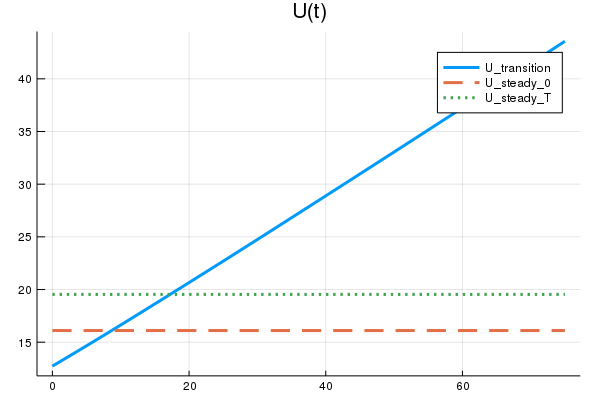

In [25]:
# generate the plot!
U_steady_0(t) = stationary_sol_0.U_bar
U_steady_T(t) = stationary_sol.U_bar

plot(solved.t, 
    [solved.U, U_steady_0, U_steady_T], 
    label = ["U_transition", "U_steady_0", "U_steady_T"] ,
    title = "U(t)", linestyle = :auto, lw = 3)

### Outstanding Issue \#2: Welfare Gains still depend on T in transition path.

The stuff above I think is correct, the one issue is why does the welfare gains, inclusive of the transition path seem to depend on T??? So change T above from 40 to 75 or 100, then the welfare gains fall alot? Why?

---
## Plotting

In [26]:
solved.U[end]

43.567042711530654

## Plots for Ω and residuals

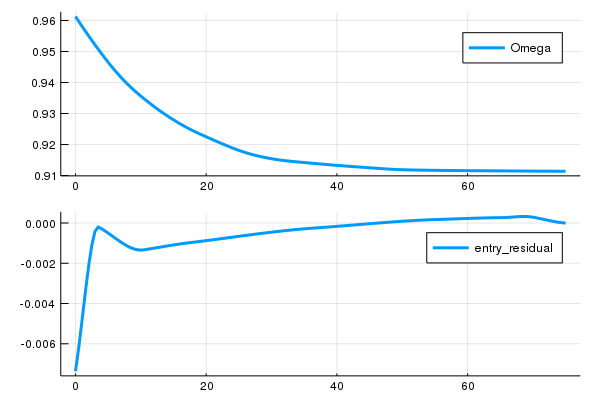

In [27]:
#solved = solved.results;
plot_Ω = plot(solved.t, solved.Ω, label = "Omega", lw = 3)
plot_residual = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot_Ω, plot_residual, layout = (2,1))

## Primary Plots

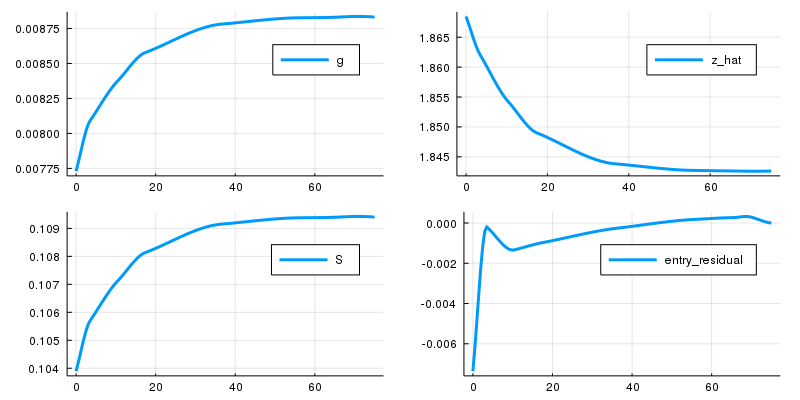

In [28]:
plot1 = plot(solved.t, solved.g, label = "g", lw = 3)
plot2 = plot(solved.t, solved.z_hat, label = "z_hat", lw = 3)
plot3 = plot(solved.t, solved.S, label = "S", lw = 3)
plot4 = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot1, plot2, plot3, plot4, layout=(2,2), size = (800, 400))

## Static Equations

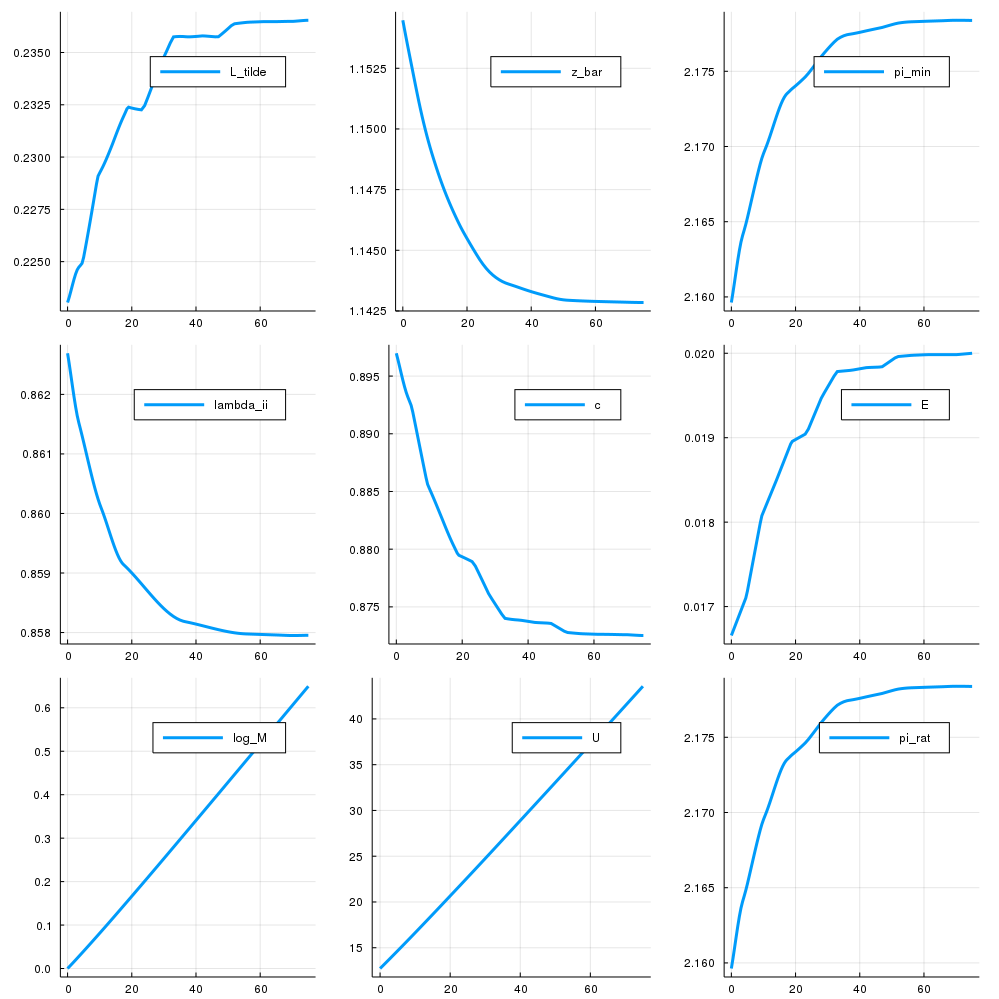

In [29]:
plot1 = plot(solved.t, solved.L_tilde, label = "L_tilde", lw = 3)
plot2 = plot(solved.t, solved.z_bar, label = "z_bar", lw = 3)
plot3 = plot(solved.t, solved.π_rat, label = "pi_min", lw = 3)
plot4 = plot(solved.t, solved.λ_ii, label = "lambda_ii", lw = 3)
plot5 = plot(solved.t, solved.c, label = "c", lw = 3)
plot6 = plot(solved.t, solved.E, label = "E", lw = 3)
plot7 = plot(solved.t, solved.log_M, label = "log_M", lw = 3)
plot8 = plot(solved.t, solved.U, label = "U", lw = 3)
plot9 = plot(solved.t, solved.π_rat, label = "pi_rat", lw = 3)
plot(plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, plot9, layout=(3,3), size = (1000, 1000))

# Welfare analysis

### `log_M(t)`

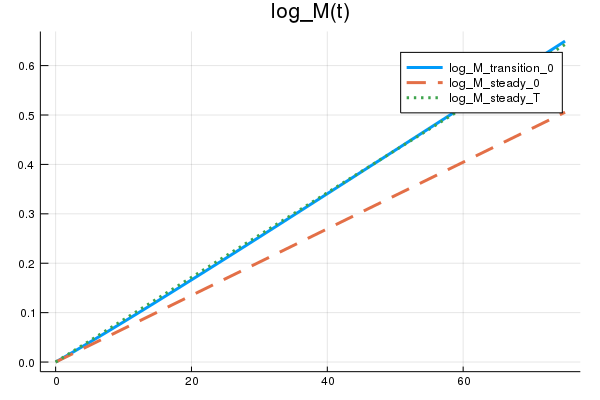

In [30]:
# define log_M with steady state g
log_M_steady_0(t) = stationary_sol_0.g * t
log_M_steady_T(t) = stationary_sol.g * t

# generate the plot!
plot(solved.t, 
    [solved.log_M, log_M_steady_0, log_M_steady_T], 
    label = ["log_M_transition_0", "log_M_steady_0", "log_M_steady_T"] ,
    title = "log_M(t)", linestyle = :auto, lw = 3)

### `Ω(t)`

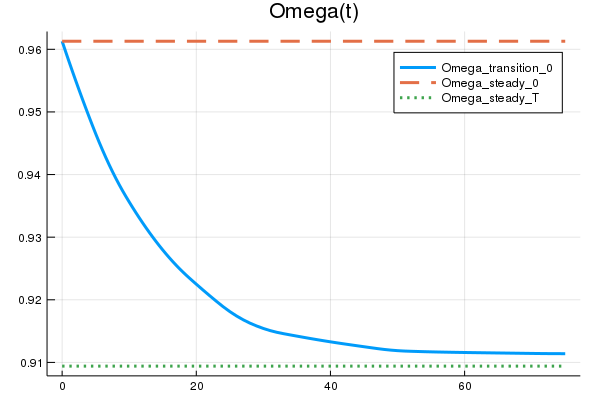

In [31]:
# define Ω function (constant)
Ω_steady_0(t) = stationary_sol_0.Ω
Ω_steady_T(t) = stationary_sol.Ω

# generate the plot!
plot(solved.t, 
    [solved.Ω, Ω_steady_0, Ω_steady_T], 
    label = ["Omega_transition_0", "Omega_steady_0", "Omega_steady_T"] ,
    title = "Omega(t)", linestyle = :auto, lw = 3)

### `c(t)`

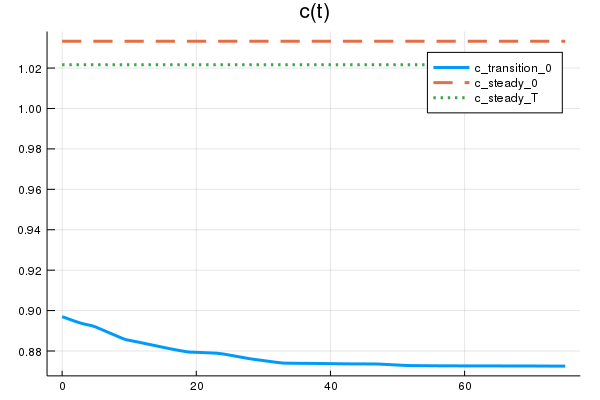

In [32]:
# define c function (constant)
c_steady_0(t) = stationary_sol_0.c
c_steady_T(t) = stationary_sol.c

# generate the plot!
plot(solved.t, 
    [solved.c, c_steady_0, c_steady_T], 
    label = ["c_transition_0", "c_steady_0", "c_steady_T"] ,
    title = "c(t)", linestyle = :auto, lw = 3)

### `U(t)`

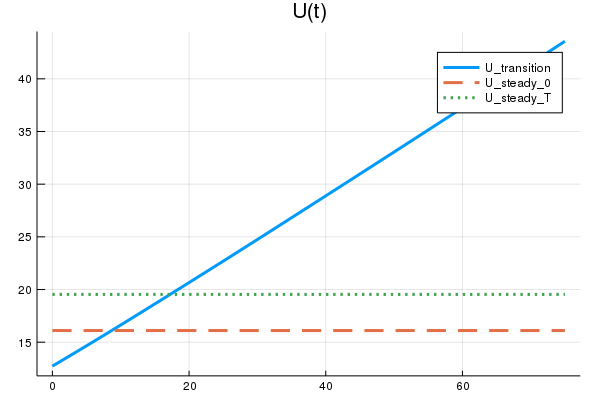

In [33]:
# generate the plot!
U_steady_0(t) = stationary_sol_0.U_bar
U_steady_T(t) = stationary_sol.U_bar

plot(solved.t, 
    [solved.U, U_steady_0, U_steady_T], 
    label = ["U_transition", "U_steady_0", "U_steady_T"] ,
    title = "U(t)", linestyle = :auto, lw = 3)

## Consumption equivalent for search threshold (`M(0)`)
See computational appendix for details.

### `M(0)` by two steady states (autarky and steady state at `T`)

In [34]:
T = solved.t[end]
consumption_equivalent(solved.U[end], stationary_sol_0.U_bar, parameters)

1.8047009895120438

### `M(0)` by autarky and transition from `t=0`

In [35]:
T = solved.t[end]
consumption_equivalent(solved.U[1], stationary_sol_0.U_bar, parameters)

0.9299551929770756

But if we include the transition path, this falls a lot. Like down to 13 percent gain. 

In [36]:
# solved 
# Run the above to see the whole dataframe

In [37]:
using DataFrames

df_stationary = DataFrame(t = -1.00, g =stationary_sol_0.g, λ_ii = stationary_sol_0.λ_ii, c = stationary_sol_0.c, L_tilde = stationary_sol_0.L_tilde, Ω = stationary_sol_0.Ω,
    π_rat = stationary_sol_0.π_rat, L_tilde_a = stationary_sol_0.L_tilde_a, L_tilde_x = stationary_sol_0.L_tilde_x, 
    L_tilde_E= stationary_sol_0.L_tilde_E, r = stationary_sol_0.r);

In [38]:
CSV.write("stationary_results.csv", df_stationary)

"stationary_results.csv"

In [39]:
df_transition = DataFrame(t = solved.t, g =solved.g, λ_ii = solved.λ_ii, c = solved.c, L_tilde = solved.L_tilde, Ω = solved.Ω,
    π_rat = solved.π_rat, L_tilde_a = solved.L_tilde_a, L_tilde_x = solved.L_tilde_x,
    L_tilde_E= solved.L_tilde_E, r = solved.r .+ parameters.δ);

In [40]:
CSV.write("transition_results.csv", df_transition)

"transition_results.csv"

In [41]:
stationary_sol_0.π_rat

1.8110075391436142

In [42]:
df_welfare = DataFrame(steady_state = lambda_ss, transition_path = lambda_tpath, growth_rate = stationary_sol.g, theta = parameters.θ);
CSV.write("welfare_results.csv", df_welfare)

"welfare_results.csv"

In [43]:
df_autarky = DataFrame(steady_state = lambda_ss_autarky, growth_rate = stationary_autarky.g, theta = parameters.θ);
CSV.write("autarky_welfare_results.csv", df_autarky)

"autarky_welfare_results.csv"

### R and W

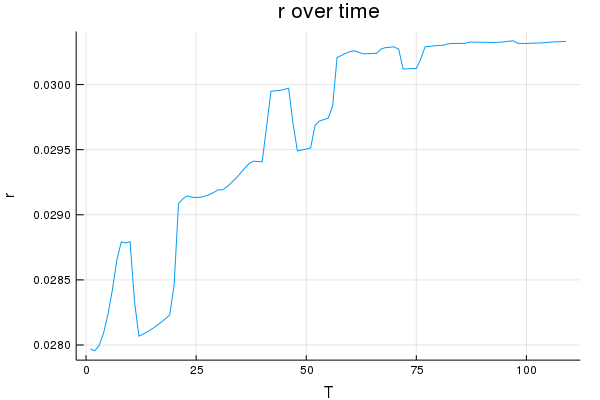

In [44]:
plot(solved.r, legend = false, title = "r over time", xlabel = "T", ylabel = "r")

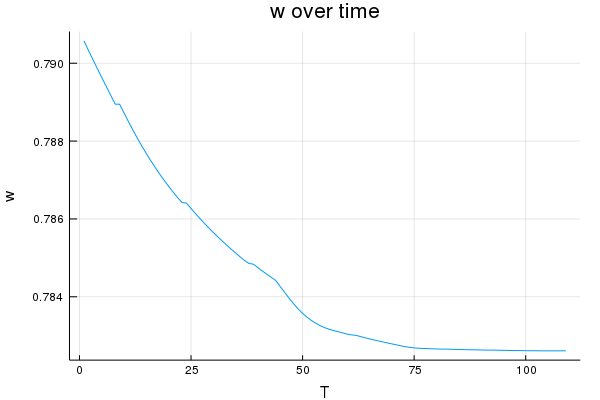

In [45]:
plot(solved.w, legend = false, title = "w over time", xlabel = "T", ylabel = "w")

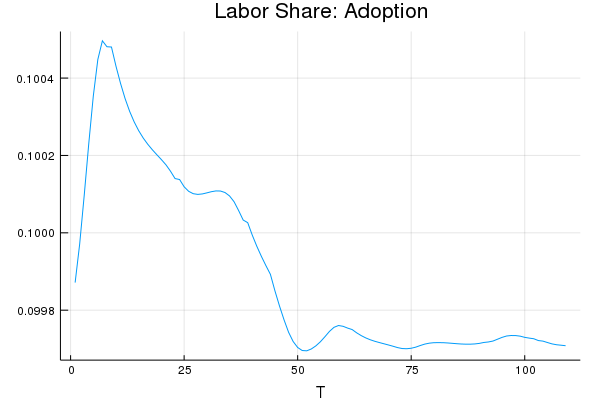

In [46]:
plot(solved.L_tilde_a, legend = false, xlabel = "T", title = "Labor Share: Adoption")

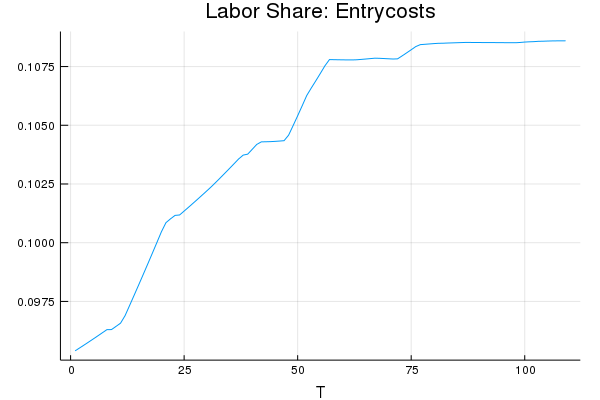

In [47]:
plot(solved.L_tilde_E, legend = false, xlabel = "T", title = "Labor Share: Entrycosts")

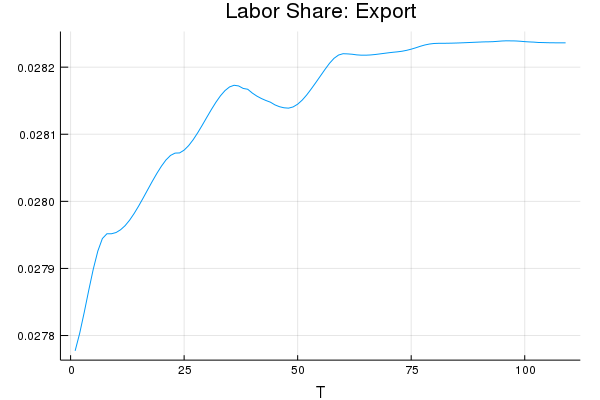

In [48]:
plot(solved.L_tilde_x, legend = false, xlabel = "T", title = "Labor Share: Export")